In [1]:
import yfinance as yf
import pandas as pd
# pip install yfinance
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from datetime import datetime # convert timestamp and revese to string
%matplotlib inline
import quantstats as qs
import pandas_ta as ta
import math



# Down Load the SPY Data Frame

In [2]:
# While closing price merely refers to the cost of shares at the end of the day, 
#the adjusted closing price considers other factors like dividends, stock splits,
#and new stock offerings. Since the adjusted closing price begins where the closing price ends,
#it can be called a more accurate measure of stocks' value.
SPYadj=yf.download("SPY")
SPYadj

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.334034,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.514212,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.568268,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.838549,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.946663,531500
...,...,...,...,...,...,...
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700
2022-12-01,408.769989,410.000000,404.750000,407.380005,407.380005,76398200


# Download ACWX data

In [39]:
#https://etfdb.com/index/msci-all-country-world-index-ex-usa/
ACWXdf=yf.download("ACWX")
ACWXdf

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-04-01,50.910000,51.360001,50.910000,51.360001,36.048759,1100
2008-04-02,51.849998,52.029999,51.849998,51.860001,36.399712,2000
2008-04-03,52.110001,52.360001,52.110001,52.320000,36.722561,1800
2008-04-04,57.549999,57.549999,52.259998,52.450001,36.813805,1700
2008-04-07,52.209999,52.709999,50.820000,52.709999,36.996307,800
...,...,...,...,...,...,...
2022-11-29,45.990002,46.209999,45.860001,45.990002,45.990002,1492500
2022-11-30,46.500000,47.119999,46.119999,46.959999,46.959999,4130100
2022-12-01,47.389999,47.459999,47.000000,47.230000,47.230000,1718400


In [ ]:
#### try vs code for qsstats

# Data Validation

In [3]:
SPYadj.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7518 entries, 1993-01-29 to 2022-12-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7518 non-null   float64
 1   High       7518 non-null   float64
 2   Low        7518 non-null   float64
 3   Close      7518 non-null   float64
 4   Adj Close  7518 non-null   float64
 5   Volume     7518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 411.1 KB


In [4]:
# note after dropna() still 7518 row; 
SPYadj.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.334034,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.514212,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.568268,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.838549,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.946663,531500
...,...,...,...,...,...,...
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700
2022-12-01,408.769989,410.000000,404.750000,407.380005,407.380005,76398200


In [40]:
ACWXdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3698 entries, 2008-04-01 to 2022-12-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3698 non-null   float64
 1   High       3698 non-null   float64
 2   Low        3698 non-null   float64
 3   Close      3698 non-null   float64
 4   Adj Close  3698 non-null   float64
 5   Volume     3698 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 202.2 KB


In [42]:
# note still 3689 rows after
ACWXdf.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-04-01,50.910000,51.360001,50.910000,51.360001,36.048759,1100
2008-04-02,51.849998,52.029999,51.849998,51.860001,36.399712,2000
2008-04-03,52.110001,52.360001,52.110001,52.320000,36.722561,1800
2008-04-04,57.549999,57.549999,52.259998,52.450001,36.813805,1700
2008-04-07,52.209999,52.709999,50.820000,52.709999,36.996307,800
...,...,...,...,...,...,...
2022-11-29,45.990002,46.209999,45.860001,45.990002,45.990002,1492500
2022-11-30,46.500000,47.119999,46.119999,46.959999,46.959999,4130100
2022-12-01,47.389999,47.459999,47.000000,47.230000,47.230000,1718400


# function to compare the two tickers

In [43]:
# note the original libarary has a know issue with the html report generation here is quote to fix under functions
##import ticker has to be string format
def compareto_BenchMarkFC(ticker1,ticker2):
    stock = qs.utils.download_returns(ticker1)
    bench = qs.utils.download_returns(ticker2)
    stock.index = stock.index.tz_convert(None)
    bench.index = bench.index.tz_convert(None)
    qs.reports.html(stock, mode='full', benchmark=bench,ouput='Strategy_vs_Bench.html')
    qs.reports.full(stock,benchmark=bench)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1993-01-29  1993-01-29
End Period                 2022-12-05  2022-12-05
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      17.0%

Cumulative Return          1,477.29%   29.19%
CAGR﹪                     9.67%       0.86%

Sharpe                     0.58        0.13
Prob. Sharpe Ratio         99.93%      78.36%
Smart Sharpe               0.54        0.12
Sortino                    0.83        0.24
Smart Sortino              0.76        0.22
Sortino/√2                 0.58        0.17
Smart Sortino/√2           0.54        0.15
Omega                      1.12        1.12

Max Drawdown               -55.19%     -55.87%
Longest DD Days            2403        1827
Volatility (ann.)          18.93%      18.82%
R^2                        0.03        0.03
Information Ratio          0.02        0.02
Calmar                     0.18        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-10,2009-03-09,2012-08-16,1772,-55.189436,-50.090595
2,2000-03-27,2002-10-09,2006-10-26,2403,-47.515853,-44.117720
3,2020-02-20,2020-03-23,2020-08-10,171,-33.717278,-29.109777
4,2022-01-04,2022-10-12,2022-12-05,335,-24.496389,-24.246519
5,2018-09-21,2018-12-24,2019-04-12,203,-19.348910,-15.952020


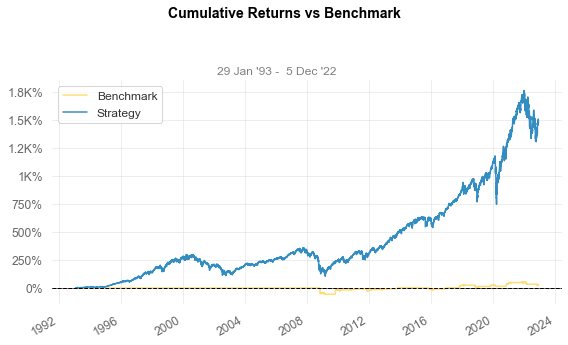

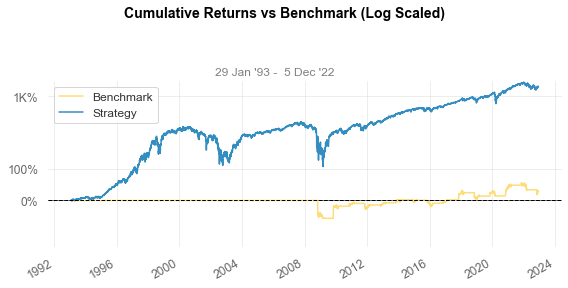

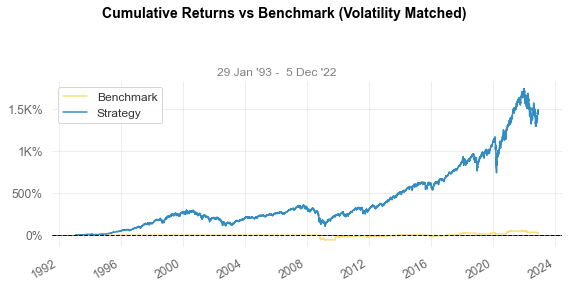

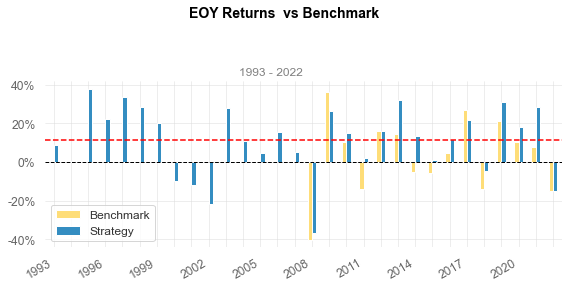

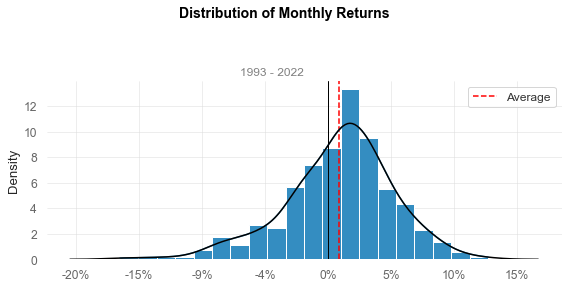

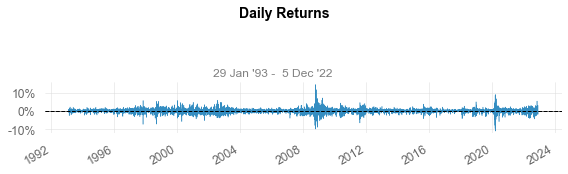

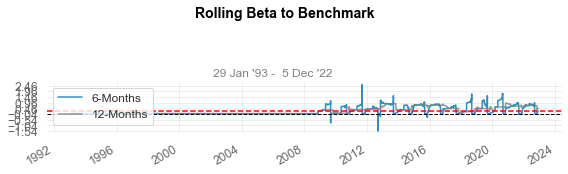

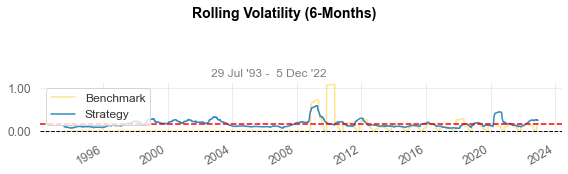

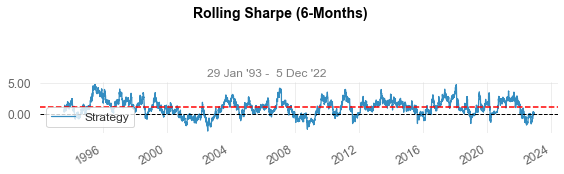

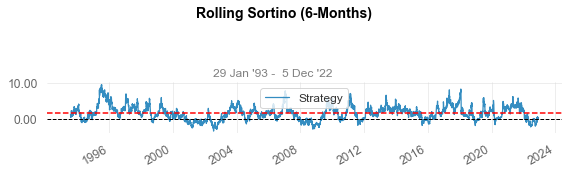

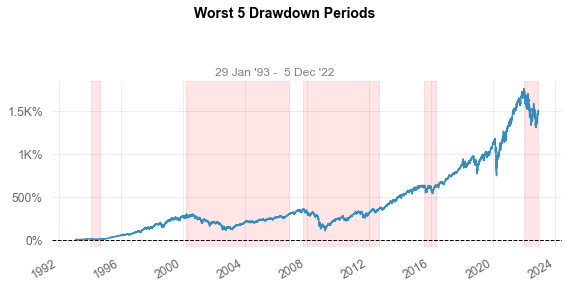

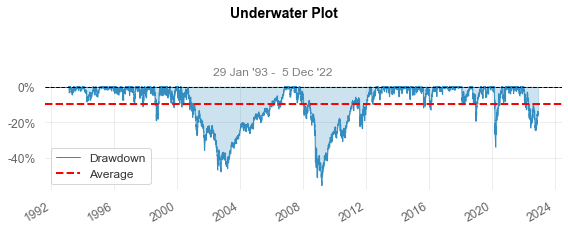

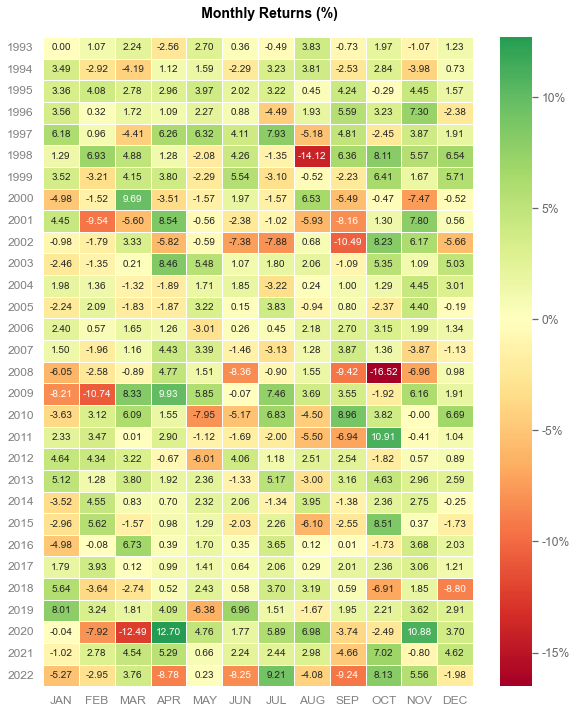

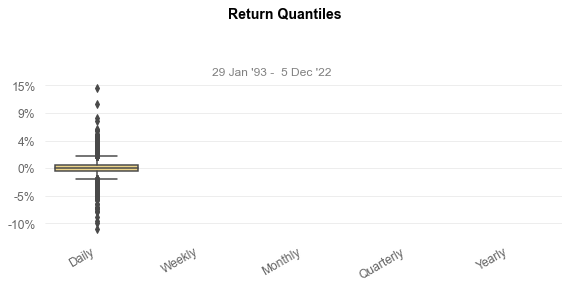

In [44]:
compareto_BenchMarkFC(ticker1="SPY",ticker2='ACWX')

# Time Handler function()1

In [7]:
# from datetime import datetime, change time stamp to str
def dftimeStaptoString(df):
    df.index.strftime("%Y-%m-%d")
    return df

# Time Handler function()2

In [8]:
# cut the time frame/period for study needs; disimble timestamp to diff columns
def timeHandlerFC(df):
    df=df.assign(year=df.index.year, month=df.index.month,day=df.index.day)
    return df

# DataFrame Time Slicer

In [9]:
# study the index for and datetime libaray
def dataFrameYrselectionFC(df,time):
    df=df.loc[df.index>=time]
    return df

In [10]:
# a way to manipulate time period, notice the index has to be original import time stamp to function well
SpyTrimmed2020=SPYadj.copy()
SpyTrimmed2020=dataFrameYrselectionFC(df=SpyTrimmed2020,time='2020-01-01')
SpyTrimmed2020
#perfect just like that, now we can manupulate any time we wanna with lots angels

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,311.117035,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,308.761169,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,309.939087,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,309.067688,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,310.714874,68296000
...,...,...,...,...,...,...
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700
2022-12-01,408.769989,410.000000,404.750000,407.380005,407.380005,76398200


# Build VolumeOverPriceTool

In [11]:
# df:dataframe from yfinance
#x price interval for underlying price
#n slicer where interval start
#m slicer where interval end
# it build analysis base on close price and sum of the history vloume over price
# seek to find the signficance of price that interpreted by volume
#480 is hard coded, seems like take a while for market to make new high, We can use df['close'].max() to replace 480
#combine with dataatrimm function very powerful, show dynamic
def volumeonPriceintervalFC(df,x,n,m):
    binn=np.arange(0,480,x).tolist()
    result=pd.cut(df['Close'],bins=binn)
    df['Range']=result
    fm=df.groupby(['Range']).sum()['Volume'][n:m]  
    gp=fm.plot(kind='bar')
    return gp,fm
    
    

(<AxesSubplot:xlabel='Range'>,
 Range
 (380, 381]    367145700
 (381, 382]    735766800
 (382, 383]    303618300
 (383, 384]    326967200
 (384, 385]    418137800
 (385, 386]    182145200
 (386, 387]    223369200
 (387, 388]    434590300
 (388, 389]    276211800
 (389, 390]    998826700
 (390, 391]    634205700
 (391, 392]    305457500
 (392, 393]    673224800
 (393, 394]    300640900
 (394, 395]    564978600
 (395, 396]    758701300
 (396, 397]    434238900
 (397, 398]    260396400
 (398, 399]    493176800
 (399, 400]    269968700
 (400, 401]    259127000
 (401, 402]    272806300
 (402, 403]    164177800
 (403, 404]            0
 (404, 405]            0
 (405, 406]    320066300
 (406, 407]    445489500
 (407, 408]    220964900
 (408, 409]    204328200
 (409, 410]     86585800
 Name: Volume, dtype: int64)

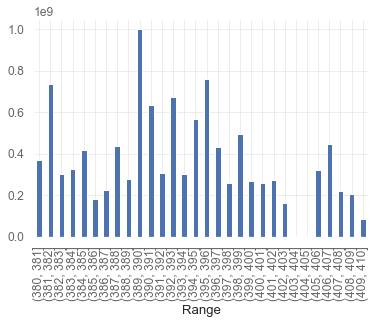

In [12]:
#combine with dataatrimm function very powerful, show dynamic
volumeonPriceintervalFC(SpyTrimmed2020,1,380,410)

# Day counts up
   

In [13]:
# we can consider add display to make it side by side
def consecutiveupdistributionFC(df):
    L=df['Adj Close'].tolist()
    dayupdistribution=[]
    adjcloseprior=L[0]
    count=0
    for x in range(len(L)-1):
        if L[x+1]>L[x]:
            count=count+1
        else:
            dayupdistribution.append(count)
            count=0
    dayupdistribution
    daycountdistributiondf=pd.DataFrame({"daycountoccurance":dayupdistribution})
    daycountdistributiondf["Occurance"]=0
    consecutiveupdstribution=daycountdistributiondf.groupby(['daycountoccurance']).count()
    consecutiveupdstribution
    nodownday=consecutiveupdstribution.copy().drop(0)
    nodownday['%ofwholeset']=round((nodownday['Occurance']/nodownday['Occurance'].sum())*100,2).astype(str)+'%'
    gpp=nodownday['Occurance'].plot(kind='bar')
    gp=consecutiveupdstribution.plot(kind='bar')
    return gpp,nodownday,consecutiveupdstribution,gp


##need to add the format string
    

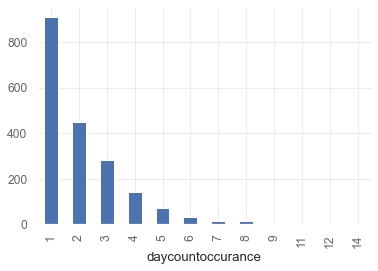

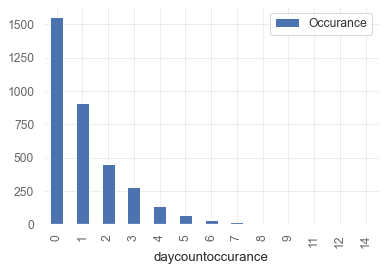

In [14]:
# note all down day marked as 0, % fullset is note a probability
a1,a2,a3,a4=consecutiveupdistributionFC(SPYadj)

In [15]:
# more intuitive way to show days up, a mean reversal strategy under way?
a2

,Occurance,%ofwholeset
daycountoccurance,,
1,908,47.29%
2,450,23.44%
3,284,14.79%
4,140,7.29%
5,71,3.7%
6,32,1.67%
7,17,0.89%
8,13,0.68%
9,2,0.1%


# Caculate rate of changes

In [ ]:
# notice a good way to understand how it work is to write a function.


# Caculate Return and Return distribution

In [16]:
# have math dependency due to math.celi()
#Kurtosis -peak and tail of the return distribution; normal distribution have Kurtosis near 0
#imperical data may be more peaky with fater tail
#Skewness # negative side tail is fatter than postive side; extrem negative movement more likely
def Caculate_ReturnFC(df):
    df['return%']=((df['Close']-df['Open'])/df['Open']*100).round(2)
    dfraw=df['return%'].copy()
    x=df['return%'].max()
    y=df['return%'].min()
    describe=df['return%'].describe()
    skewness=st.skew(df['return%'].dropna())
    kurtosiss=st.kurtosis(df['return%'].dropna())
    # notcie shapiro not effective if n>5000
    #shapiro is a fair estimate on probability wise, still not a gurantee judgement
    # will sample 5000 a good way to go?
    p_value=st.shapiro(df['return%'].dropna().sample(5000))[1]
    # in scipy it return excess kurtosis as defualt
    print(f"daily return excess kurtosis(after -3 from normal) at {kurtosiss}")
    print(f"daily return skewness at {skewness}")
    print(f"daily return p_value at {p_value}")
    if p_value<=0.05:
        print("Null hypothesis of normality is rejected.")
    else:
        print("Null hypothesis of normality is accepted.")
    L=np.arange(y,math.ceil(x),1)
    df['daily_%return_range']=pd.cut(df['return%'],bins=L)
    gp=df.groupby(['daily_%return_range']).count()['Close'].plot(kind='bar')
    df['return%']=(df['return%']).astype(str)+'%'
    df=df.drop(columns='daily_%return_range')
    
    # {"stdv":[1,2,3],"normal:[]"}

    dfraww=dfraw.to_frame()
    stdd=dfraww.std()
    meann=dfraww.mean()
    #normal distribution prama
    y=[0.6820,0.9540,0.99]
    Distr=[]
    for x in y:
        m=x*len(SPYadj)
        Distr.append(m)
    Distr

    upper1std=meann+stdd
    lower1std=meann-stdd
    upper2std=meann+(2*stdd)
    lower2std=meann-(2*stdd)
    upper3std=meann+(3*stdd)
    lower3std=meann-(3*stdd)
    Distrbin=[f"{round(lower1std[0],4)} ~{round(upper1std[0],4)}",\
              f"{round(lower2std[0],4)}~{round(upper2std[0],4)}",\
              f"{round(lower3std[0],4)}~{round(upper3std[0],4)}"]
    a1=len(dfraww.loc[(dfraww['return%']>lower2std[0] )& (dfraww['return%']<upper1std[0])])
    a2=len(dfraww.loc[(dfraww['return%']>lower2std [0])& (dfraww['return%']<upper2std[0])])
    a3=len(dfraww.loc[(dfraww['return%']>=lower2std[0] )& (dfraww['return%']<=upper3std[0])])
    actual=[]
    actual.append(a1)
    actual.append(a2)
    actual.append(a3)
    actual
    normalFreq=pd.DataFrame({'Distribin':Distrbin})
    normalFreq['Empirical']=actual
    normalFreq['Normal']=Distr
    normalFreq
    
    

    return df,gp,describe,normalFreq,dfraw
#we can unpack a4 for study 
# how can we create a normal distribution one to fit our data


daily return excess kurtosis(after -3 from normal) at 8.483647181988125
daily return skewness at -0.057723072734593886
daily return p_value at 0.0
Null hypothesis of normality is rejected.


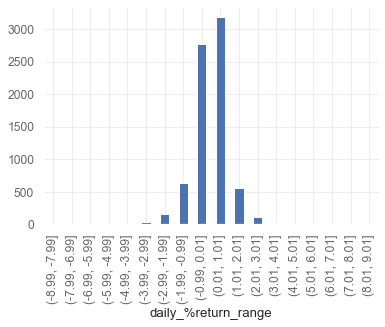

In [17]:
a1,a2,a3,a4,a5=Caculate_ReturnFC(SPYadj)

In [18]:
a1

,Open,High,Low,Close,Adj Close,Volume,return%
Date,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.334034,1003200,-0.07%
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.514212,480500,0.64%
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.568268,201300,0.28%
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.838549,529400,0.91%
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.946663,531500,0.07%
...,...,...,...,...,...,...,...
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000,-0.21%
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700,3.08%
2022-12-01,408.769989,410.000000,404.750000,407.380005,407.380005,76398200,-0.34%


In [19]:
a3

count    7518.000000
mean        0.004491
std         0.974138
min        -8.990000
25%        -0.420000
50%         0.040000
75%         0.470000
max         9.300000
Name: return%, dtype: float64

In [20]:
# compare the number of occurange base on index:0->1sigma;
#index:1->2sigma
#index2->3 sigma
#we can notice how it is disobeyed among diff bins
a4

,Distribin,Empirical,Normal
0,-0.9696 ~0.9786,6518,5127.276
1,-1.9438~1.9528,7115,7172.172
2,-2.9179~2.9269,7234,7442.820


# Calculate ATR- Historical vol

In [21]:
# beautiful set up, it allow u to scope atr for realiize vol by anchor at today's date
def anchoredATRCalFC(df):
    df['TrueRange']=df['High']-df['Low']
    atrSpy=df.copy().ta.reverse.reset_index()
    rolling2D=[((atrSpy['TrueRange'][x]+atrSpy['TrueRange'][x+1])/2)/(atrSpy['Open'][x])for x in range(len(SPYadj)-1)]
    rolling2Draw=pd.Series(rolling2D)
    atrSpy['rolling2D']=(rolling2Draw*100).round(5).astype(str)+'%'
    
  #find out the atr change overtime from anchored date
    a={"years":["5days","20days","60days","1year","3year","5years","10years","20years","50years"]}
    b={"Days":[5,20,60,250,750,1250,2500,5000,12500]}
    c={"AvgDailyATRbaseonPeriod":[]}
    for x in b['Days']:
        #60period we need to add one digit; notice it start from 0 and exlude the last one on slicer,balance out
        periodmean=str(round((rolling2Draw[:x+1].mean()*100),3))+'%'
        c['AvgDailyATRbaseonPeriod'].append(periodmean)
    anchoredATR=pd.DataFrame({'years':a['years'],'Days':b['Days'],\
                              'AvgDailyATRbaseonPeriod':c['AvgDailyATRbaseonPeriod']}).T
    return atrSpy,rolling2Draw,anchoredATR

In [22]:
aatr,batr,catr=anchoredATRCalFC(SPYadj)
aatr

,Date,Open,High,Low,Close,Adj Close,Volume,return%,daily_%return_range,TrueRange,rolling2D
0,2022-12-05,403.950012,404.929993,398.170013,399.589996,399.589996,77042500,-1.08%,"(-1.99, -0.99]",6.759979,1.54474%
1,2022-12-02,402.250000,407.859985,402.140015,406.910004,406.910004,85273900,1.16%,"(1.01, 2.01]",5.719971,1.36358%
2,2022-12-01,408.769989,410.000000,404.750000,407.380005,407.380005,76398200,-0.34%,"(-0.99, 0.01]",5.250000,2.37909%
3,2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700,3.08%,"(3.01, 4.01]",14.199982,2.30094%
4,2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000,-0.21%,"(-0.99, 0.01]",4.000000,1.22459%
...,...,...,...,...,...,...,...,...,...,...,...
7513,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.946663,531500,0.07%,"(0.01, 1.01]",0.625000,1.21612%
7514,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.838549,529400,0.91%,"(0.01, 1.01]",0.468750,0.80929%
7515,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.568268,201300,0.28%,"(0.01, 1.01]",0.250000,0.60071%
7516,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.514212,480500,0.64%,"(0.01, 1.01]",0.281250,0.56859%


In [23]:
# here we anchor at today's date and look back the historical data
# to see how daily vol high-low: trending; max lookback 50yrs
catr

,0,1,2,3,4,5,6,7,8
years,5days,20days,60days,1year,3year,5years,10years,20years,50years
Days,5,20,60,250,750,1250,2500,5000,12500
AvgDailyATRbaseonPeriod,1.616%,1.497%,1.926%,1.807%,1.532%,1.339%,1.096%,1.26%,1.314%


# Caculate Log Return

# Build Graphic Generator

In [24]:
# note input has to be us stock ticker a commpany wiht ""; eg input="SPY"(StockTickers)
# start/end date has to be "YYYY-MM-DD" format
def generateachart(input,start,end): # is this the dependency not within the function?# notice need to put diff quotation on it
    ticker=yf.Ticker(input)
    Fetched=ticker.history(start=start,end=end)
    plt.figure(figsize=(10,6))
    performance=plt.plot(Fetched['Close'])
    plt.grid()
    plt.show()
# looking for the documentary to define the functions

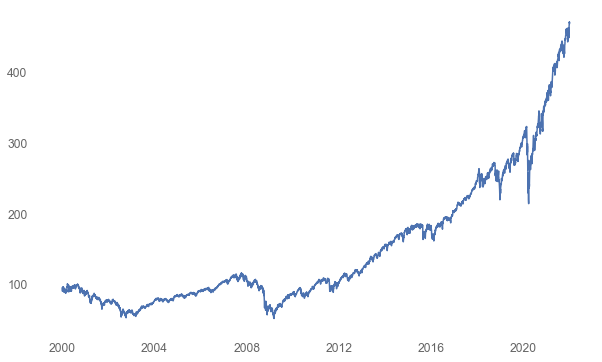

In [26]:
generateachart(input='Spy',start='2000-01-01',end='2022-01-01')

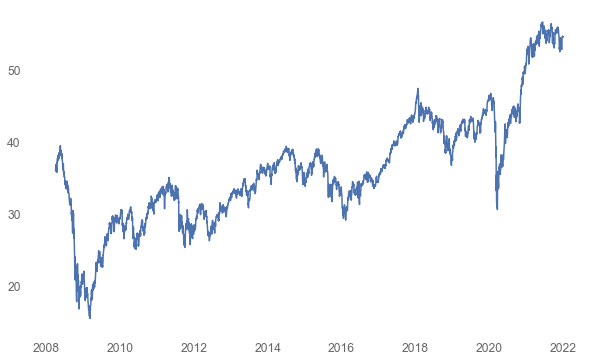

In [27]:
generateachart('ACWX','2000-01-01','2022-01-01') # note here data only avaliable since 2008

In [28]:
SpyTrimmed2020.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 738 entries, 2020-01-02 to 2022-12-05
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Open       738 non-null    float64 
 1   High       738 non-null    float64 
 2   Low        738 non-null    float64 
 3   Close      738 non-null    float64 
 4   Adj Close  738 non-null    float64 
 5   Volume     738 non-null    int64   
 6   Range      738 non-null    category
dtypes: category(1), float64(5), int64(1)
memory usage: 65.4 KB


# BollingerBand

In [31]:
def showBbandsFC(df):
    a=df.ta.bbands(close='Adj Close',length=20,append=True)
    b=df[['BBU_20_2.0','Adj Close','BBL_20_2.0']]
    gp=b.plot()
    return gp,df

In [35]:
#used the trim function to shorten the data frame match AWCX existance
#2008-4-01
Spytrimmed2008=SPYadj.copy()
Spytrimmed2008=dataFrameYrselectionFC(Spytrimmed2008,'2008-4-1')

(<AxesSubplot:xlabel='Date'>,
                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2008-04-01  133.610001  136.839996  133.509995  136.610001  102.735786   
 2008-04-02  137.050003  137.669998  135.979996  136.699997  102.803452   
 2008-04-03  135.960007  137.440002  135.710007  137.039993  103.059151   
 2008-04-04  137.119995  137.960007  136.119995  136.889999  102.946373   
 2008-04-07  137.869995  138.570007  136.740005  136.960007  102.999031   
 ...                ...         ...         ...         ...         ...   
 2022-11-29  396.049988  397.299988  393.299988  395.230011  395.230011   
 2022-11-30  395.489990  407.679993  393.480011  407.679993  407.679993   
 2022-12-01  408.769989  410.000000  404.750000  407.380005  407.380005   
 2022-12-02  402.250000  407.859985  402.140015  406.910004  406.910004   
 2022-12-05  403.950012  404.929993  398.170013  399.589996  399.58999

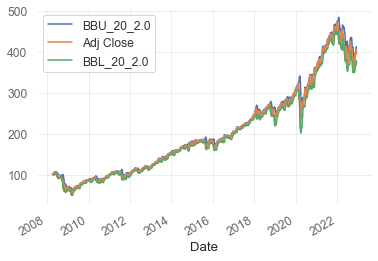

In [36]:
showBbandsFC(df=Spytrimmed2008)

(<AxesSubplot:xlabel='Date'>,
                  Open       High        Low      Close  Adj Close   Volume  \
 Date                                                                         
 2008-04-01  50.910000  51.360001  50.910000  51.360001  36.048763     1100   
 2008-04-02  51.849998  52.029999  51.849998  51.860001  36.399700     2000   
 2008-04-03  52.110001  52.360001  52.110001  52.320000  36.722565     1800   
 2008-04-04  57.549999  57.549999  52.259998  52.450001  36.813805     1700   
 2008-04-07  52.209999  52.709999  50.820000  52.709999  36.996300      800   
 ...               ...        ...        ...        ...        ...      ...   
 2022-11-29  45.990002  46.209999  45.860001  45.990002  45.990002  1492500   
 2022-11-30  46.500000  47.119999  46.119999  46.959999  46.959999  4130100   
 2022-12-01  47.389999  47.459999  47.000000  47.230000  47.230000  1718400   
 2022-12-02  46.810001  47.369999  46.799999  47.220001  47.220001  2660400   
 2022-12-05  47.139999

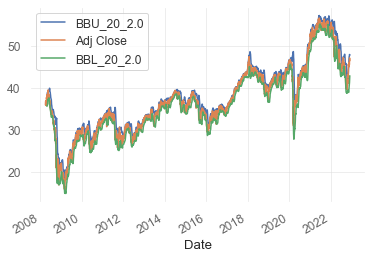

In [38]:
# A comparable Bollinger band study to see if there is signifcant statistic boundary difference;
# this can be use as statistic boundary for future algo building
showBbandsFC(df=ACWXdf)